In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight



# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
!pip install contractions
# !pip uninstall scikit-learn imbalanced-learn -y
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 88.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
!pip install numpy
!pip install gensim
!pip install jax
# Load the GloVe pre-trained embedding
import gensim.downloader as api
embedding_model = api.load('fasttext-wiki-news-subwords-300')  # 300-dimensional


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
[==================================================] 100.0% 958.5/958.4MB downloaded


In [3]:
import contractions# 1. Load the dataset
df = pd.read_csv('/content/financial_phrase.csv')

# 2. Text cleaning function
def clean_text(text):
    # Lowercase
    text = text.lower()
# Fix contractions first (before other processing)
    text = contractions.fix(text)
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove numbers and special characters (keep only letters)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r"[^\w\s$%€£]", '', text)

    # Enhanced number/unit handling
    text = re.sub(r'\$\d+\.?\d*[mb]?\b', '<CURRENCY>', text)
    text = re.sub(r'\d+%', '<PERCENT>', text)
    text = re.sub(r'\b\d+\b', '<NUM>', text)


    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(words)

# Apply cleaning
df['cleaned_text'] = df['text'].apply(clean_text)


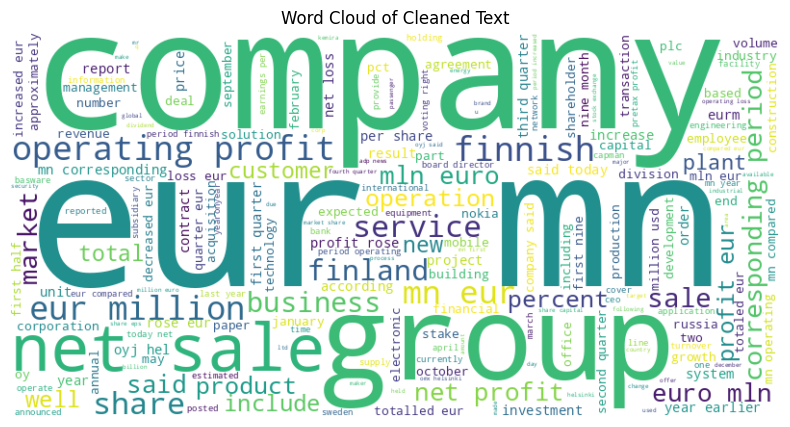


Top 20 Frequent Words:
eur: 954
mn: 494
company: 384
profit: 325
net: 292
sale: 278
million: 267
share: 263
finnish: 219
said: 206
operating: 202
mln: 198
period: 194
year: 184
quarter: 170
group: 160
euro: 155
service: 137
finland: 132
market: 128


In [4]:
# 3. Visualize cleaned data
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Text")
plt.show()

# Top 20 Frequent Words
words = ' '.join(df['cleaned_text']).split()
word_freq = Counter(words).most_common(20)
print("\nTop 20 Frequent Words:")

for word, freq in word_freq:
    print(f"{word}: {freq}")


In [5]:
# 4. Label Encoding
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Show label mapping
print("\nLabel Encoding Mapping:")
for index, class_name in enumerate(label_encoder.classes_):
    print(f"{index}: {class_name}")

# 5. Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['label_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=df['label_encoded']  # Maintain class balance
)


Label Encoding Mapping:
0: negative
1: neutral
2: positive


In [6]:
# 6. Tokenization
tokenizer = Tokenizer(
    num_words=5000,  # Limit vocabulary size
    oov_token='<OOV>',
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'  # Basic punctuation filter
)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 7. Dynamic Padding (95th percentile)
sequence_lengths = [len(seq) for seq in X_train_seq]
padding_length = int(np.percentile(sequence_lengths, 95))
coverage = sum(1 for seq in sequence_lengths if seq <= padding_length) / len(sequence_lengths)

print("\nSequence Statistics:")
print(f"- Vocabulary size: {len(tokenizer.word_index)}")
print(f"- 95th percentile length: {padding_length} (covers {coverage:.1%} of samples)")
print(f"- Max length: {max(sequence_lengths)}")

# Apply padding
X_train_pad = pad_sequences(
    X_train_seq,
    maxlen=padding_length,
    padding='post',
    truncating='post'
)
X_test_pad = pad_sequences(
    X_test_seq,
    maxlen=padding_length,
    padding='post',
    truncating='post'
)

# 8. Class Weight Calculation
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in np.unique(y_train)}
print(f"\nClass Weight Dictionary: {class_weight_dict}")

# 9. Final Output Shapes
print("\nFinal Output Shapes:")
print(f"X_train_pad: {X_train_pad.shape}")
print(f"X_test_pad: {X_test_pad.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


Sequence Statistics:
- Vocabulary size: 4407
- 95th percentile length: 22 (covers 95.0% of samples)
- Max length: 38

Class Weight Dictionary: {0: 2.494490358126722, 1: 0.5423779574722971, 2: 1.3238304093567252}

Final Output Shapes:
X_train_pad: (1811, 22)
X_test_pad: (453, 22)
y_train: (1811,)
y_test: (453,)


In [7]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 242, 1: 1113, 2: 456}


In [8]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# Assuming X_train_pad and y_train are NumPy arrays
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Resample
X_resampled, y_resampled = ros.fit_resample(X_train_pad, y_train)



# Check new class distribution
unique, counts = np.unique(y_resampled, return_counts=True)
print("New class distribution:", dict(zip(unique, counts)))

New class distribution: {0: 1113, 1: 1113, 2: 1113}


In [9]:
import time
training_times = {}

In [24]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Config ---
vocab_size = 5000       # Adjust based on your tokenizer's vocab
embedding_dim = 128     # You can tune this
sequence_length = 22    # As per your padded input

# --- Model ---
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))
model1.add(SimpleRNN(64, return_sequences=False))
model1.add(Dropout(0.5))  # Helps reduce overfitting
model1.add(Dense(32, activation='relu'))
model1.add(Dense(3, activation='softmax'))  # 3 classes

# --- Compile ---
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
# --- Train ---
history1 = model1.fit(X_resampled, y_resampled,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)
end_time = time.time()
training_times['model1'] = end_time - start_time


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5380 - loss: 0.9303 - val_accuracy: 0.3952 - val_loss: 1.0906
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8872 - loss: 0.3186 - val_accuracy: 0.8952 - val_loss: 0.2458
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9453 - loss: 0.1571 - val_accuracy: 0.9192 - val_loss: 0.2488
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9686 - loss: 0.1035 - val_accuracy: 0.9147 - val_loss: 0.2209
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9814 - loss: 0.0673 - val_accuracy: 0.9596 - val_loss: 0.1045
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9778 - loss: 0.0642 - val_accuracy: 0.9551 - val_loss: 0.1316
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9916 - loss: 0.0377 - val_accuracy: 0.9596 - val_loss: 0.1083
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9794 - loss: 0.0616 - val_accuracy: 0.9910 - val_loss: 0.0283
Ep

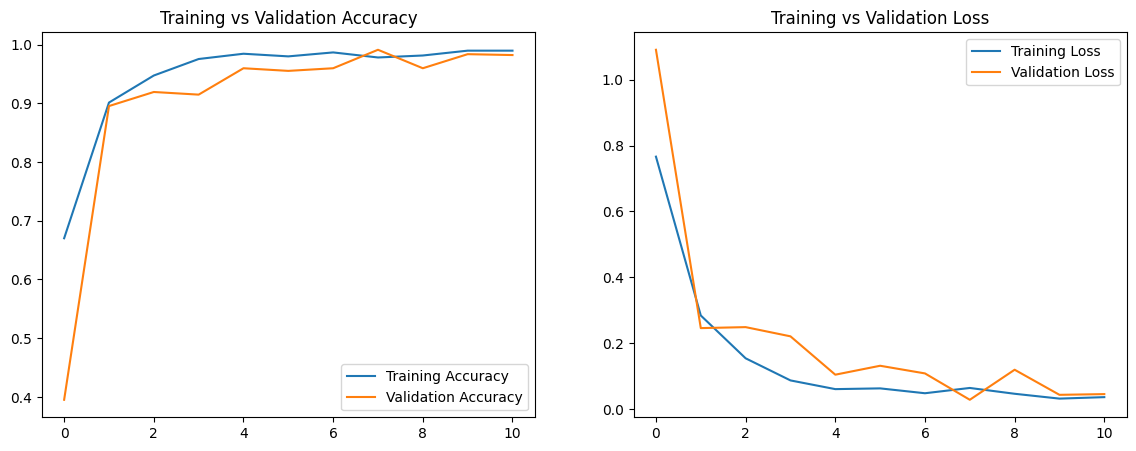

In [25]:
def plot_training_history(history):  # Generic parameter name
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training vs Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training vs Validation Loss')
    plt.show()

# Call it with your history object
plot_training_history(history1)  # Pass "history1"

In [12]:
# Evaluate
test_loss, test_accuracy = model1.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7679 - loss: 1.1717
Test Accuracy: 0.7726


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


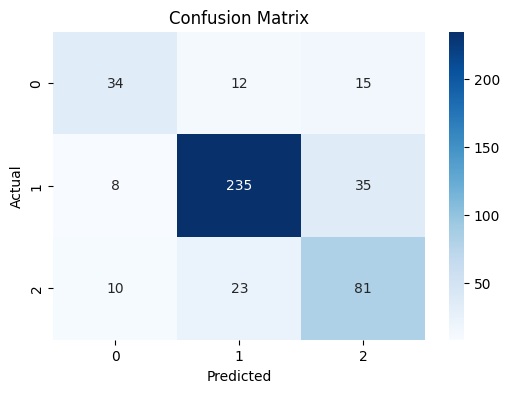

Classification Report:

              precision    recall  f1-score   support

           0     0.6538    0.5574    0.6018        61
           1     0.8704    0.8453    0.8577       278
           2     0.6183    0.7105    0.6612       114

    accuracy                         0.7726       453
   macro avg     0.7142    0.7044    0.7069       453
weighted avg     0.7778    0.7726    0.7738       453



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predictions
y_pred = model1.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=1)  # Convert softmax outputs to class labels

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes, digits=4))


In [14]:


import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences



# --- Config ---
vocab_size = 5000                  # Based on tokenizer
embedding_dim = 128
sequence_length = 22              # Padded sequence length
num_classes = 3
# 2. Stratified train/val split
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# ------------------------------
# 3. Model Definition
# ------------------------------
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length),

    LSTM(64, return_sequences=False),           # Reduced size for stability
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ------------------------------
# 4. Callbacks
# ------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6)
start_time = time.time()
# ------------------------------
# 5. Training
# ------------------------------
history2 = model2.fit(
    X_train_final, y_train_final,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_scheduler]
)
end_time = time.time()
training_times['model2'] = end_time - start_time
# ------------------------------
# 6. Final Evaluation
# ------------------------------
test_loss, test_accuracy = model2.evaluate(X_test_pad, y_test)
print(f"\n Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")



Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3338 - loss: 1.0962 - val_accuracy: 0.5958 - val_loss: 0.8509 - learning_rate: 5.0000e-04
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6363 - loss: 0.7310 - val_accuracy: 0.6766 - val_loss: 0.6061 - learning_rate: 5.0000e-04
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7242 - loss: 0.5132 - val_accuracy: 0.8323 - val_loss: 0.4157 - learning_rate: 5.0000e-04
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9068 - loss: 0.2816 - val_accuracy: 0.8608 - val_loss: 0.3834 - learning_rate: 5.0000e-04
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9453 - loss: 0.1913 - val_accuracy: 0.8428 - val_loss: 0.4806 - learning_rate: 5.0000e-04
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9588 - loss: 0.1503 - val_accuracy: 0.9147 - val_loss: 0.3295 - learning_rate: 5.0000e-04
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9760 - loss: 0.0796 -

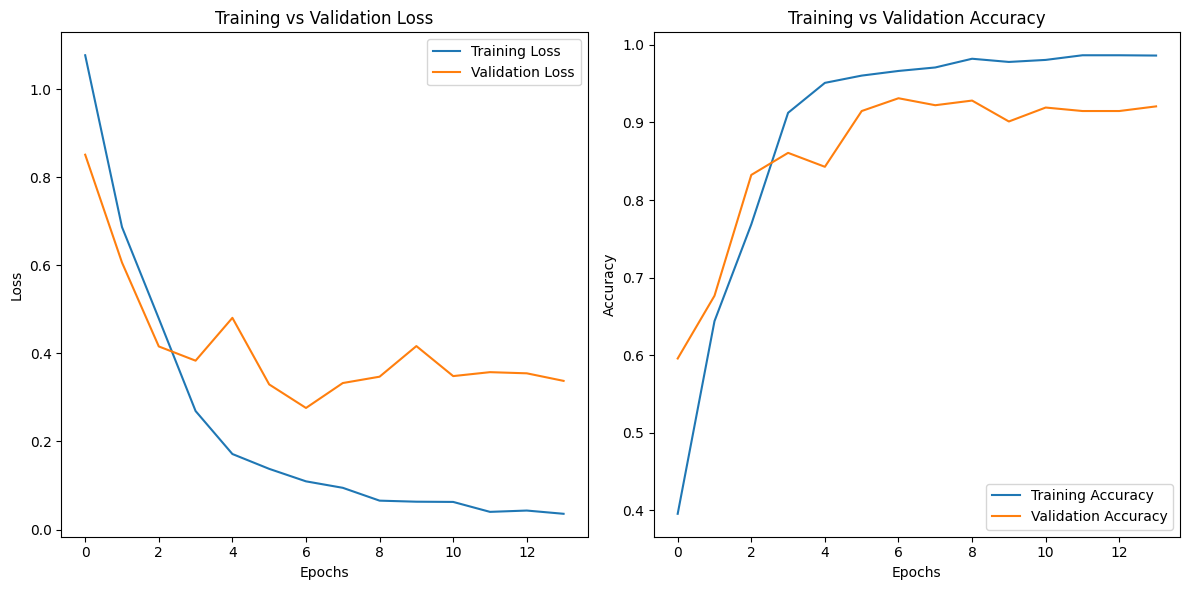

In [15]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Training Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Then call it with your actual history object
plot_training_history(history2)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


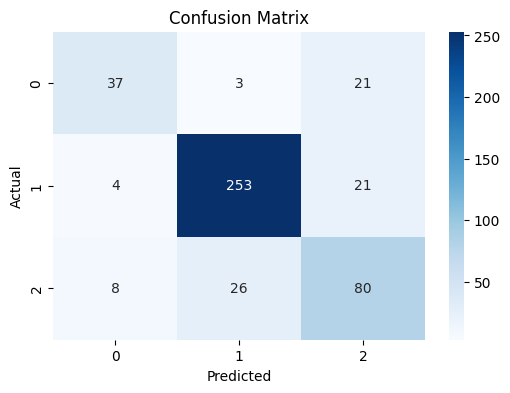

Classification Report:

              precision    recall  f1-score   support

           0     0.7551    0.6066    0.6727        61
           1     0.8972    0.9101    0.9036       278
           2     0.6557    0.7018    0.6780       114

    accuracy                         0.8168       453
   macro avg     0.7693    0.7395    0.7514       453
weighted avg     0.8173    0.8168    0.8157       453



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predictions
y_pred = model2.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=1)  # Convert softmax outputs to class labels

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes, digits=4))


In [17]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------
# Parameters
# ----------------------------
vocab_size = 5000
embedding_dim = 300
sequence_length = 22
num_classes = 3

# ----------------------------
# Build Embedding Matrix
# ----------------------------
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

# ----------------------------
# Compute Class Weights
# ----------------------------
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_resampled),
    y=y_resampled
)
class_weights = dict(enumerate(class_weights))

# ----------------------------
# Stratified Train/Val Split
# ----------------------------
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in sss.split(X_resampled, y_resampled):
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]
start_time = time.time()
# ----------------------------
# Model Definition
# ----------------------------
model3 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=sequence_length,
              trainable=False),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# ----------------------------
# Compile Model
# ----------------------------
optimizer = Adam(learning_rate=0.0005)
model3.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ----------------------------
# Callbacks
# ----------------------------
early_stop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

# ----------------------------
# Train Model
# ----------------------------
history3 = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights
)
end_time = time.time()
training_times['model3'] = end_time - start_time
# ----------------------------
# Evaluation
# ----------------------------
loss, accuracy = model3.evaluate(X_val, y_val)
print(f"\nValidation Accuracy: {accuracy:.4f}, Validation Loss: {loss:.4f}")

# ----------------------------
# Confusion Matrix & Report
# ----------------------------
y_pred = np.argmax(model3.predict(X_val), axis=1)
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4842 - loss: 1.0126 - val_accuracy: 0.6272 - val_loss: 0.7478
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6368 - loss: 0.7398 - val_accuracy: 0.6766 - val_loss: 0.6416
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7134 - loss: 0.6077 - val_accuracy: 0.7141 - val_loss: 0.5754
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7862 - loss: 0.5027 - val_accuracy: 0.7680 - val_loss: 0.4898
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8297 - loss: 0.4185 - val_accuracy: 0.8144 - val_loss: 0.4190
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8659 - loss: 0.3457 - val_accuracy: 0.8563 - val_loss: 0.3653
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8678 - loss: 0.3159 - val_accuracy: 0.8817 - val_loss: 0.3182
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9021 - loss: 0.2427 - val_accuracy: 0.8668 - val_loss: 0.3200


In [18]:
# Evaluate on test set
test_loss, test_accuracy = model3.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Generate classification report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = np.argmax(model3.predict(X_test_pad), axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8578 - loss: 0.6075
Test Accuracy: 0.8543
Test Loss: 0.6480
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Confusion Matrix:
[[ 50   2   9]
 [  7 258  13]
 [ 16  19  79]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.82      0.75        61
           1       0.92      0.93      0.93       278
           2       0.78      0.69      0.73       114

    accuracy                           0.85       453
   macro avg       0.80      0.81      0.80       453
weighted avg       0.86      0.85      0.85       453



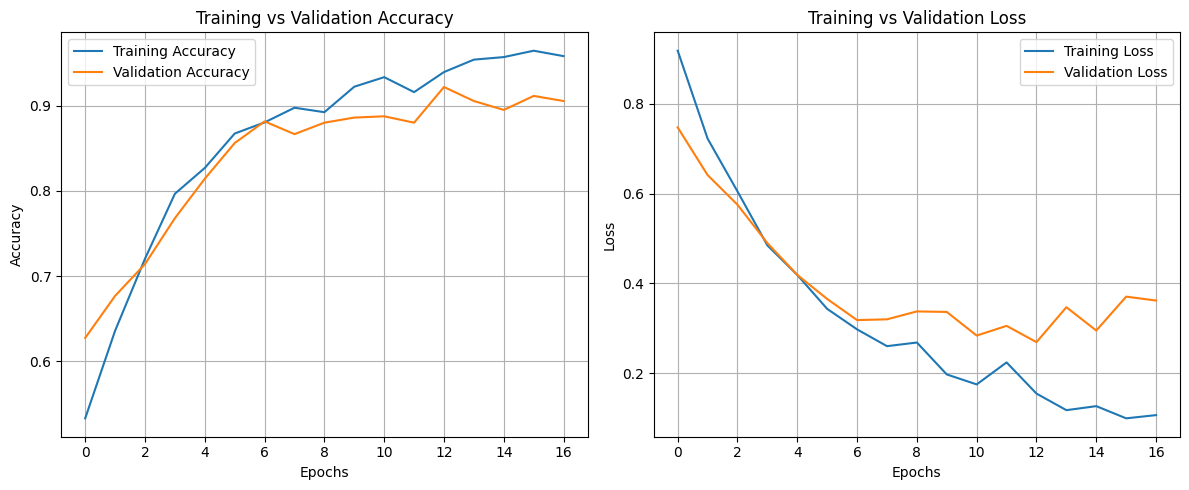

In [19]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy' )
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


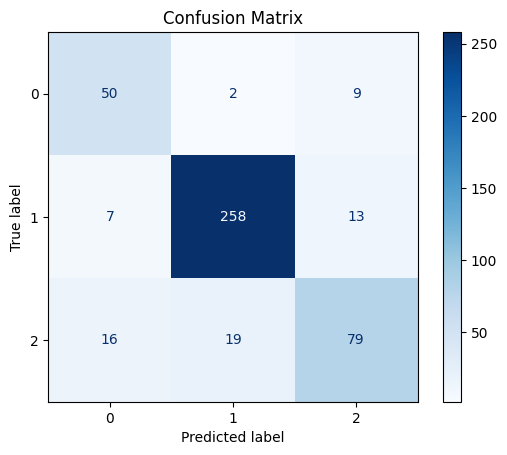

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions from the model
y_pred_probs = model3.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)  # Use argmax for multiclass classification

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()



Evaluating Model 1: Simple RNN...
Model 1: Simple RNN Accuracy: 0.7748
Model 1: Simple RNN Loss: 1.0443
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Classification Report for Model 1: Simple RNN:

              precision    recall  f1-score   support

           0       0.62      0.43      0.50        61
           1       0.92      0.84      0.88       278
           2       0.58      0.81      0.68       114

    accuracy                           0.77       453
   macro avg       0.71      0.69      0.69       453
weighted avg       0.80      0.77      0.78       453



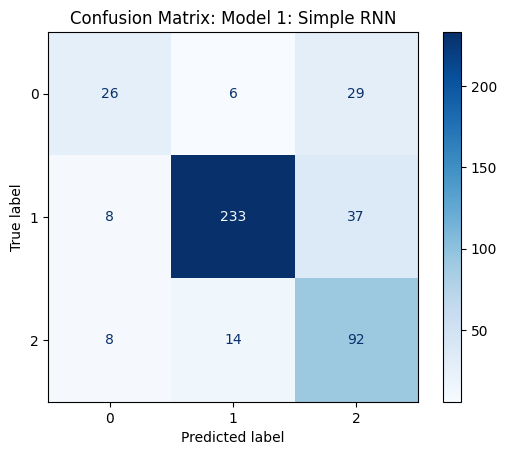

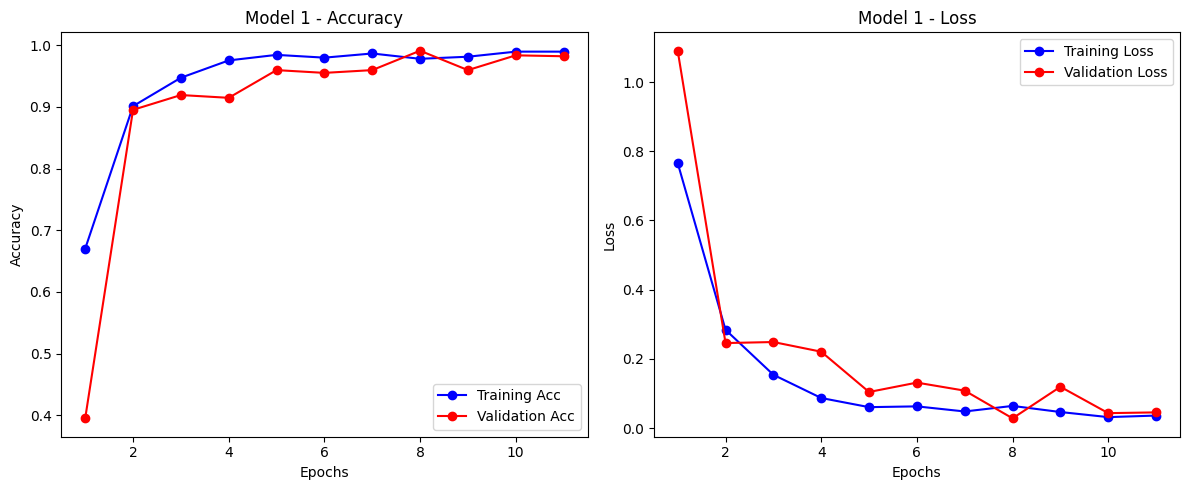


Evaluating Model 2: LSTM + Word Embedding...
Model 2: LSTM + Word Embedding Accuracy: 0.8168
Model 2: LSTM + Word Embedding Loss: 0.7401
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Classification Report for Model 2: LSTM + Word Embedding:

              precision    recall  f1-score   support

           0       0.76      0.61      0.67        61
           1       0.90      0.91      0.90       278
           2       0.66      0.70      0.68       114

    accuracy                           0.82       453
   macro avg       0.77      0.74      0.75       453
weighted avg       0.82      0.82      0.82       453



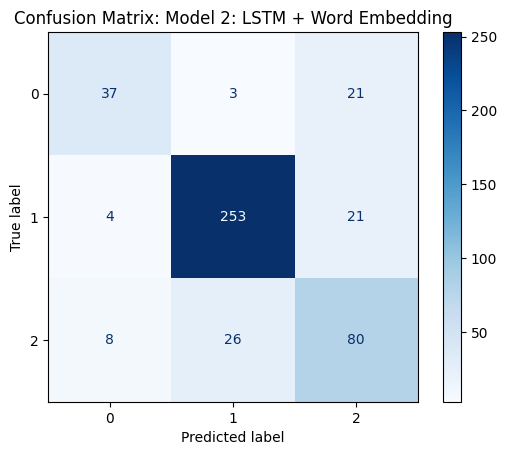

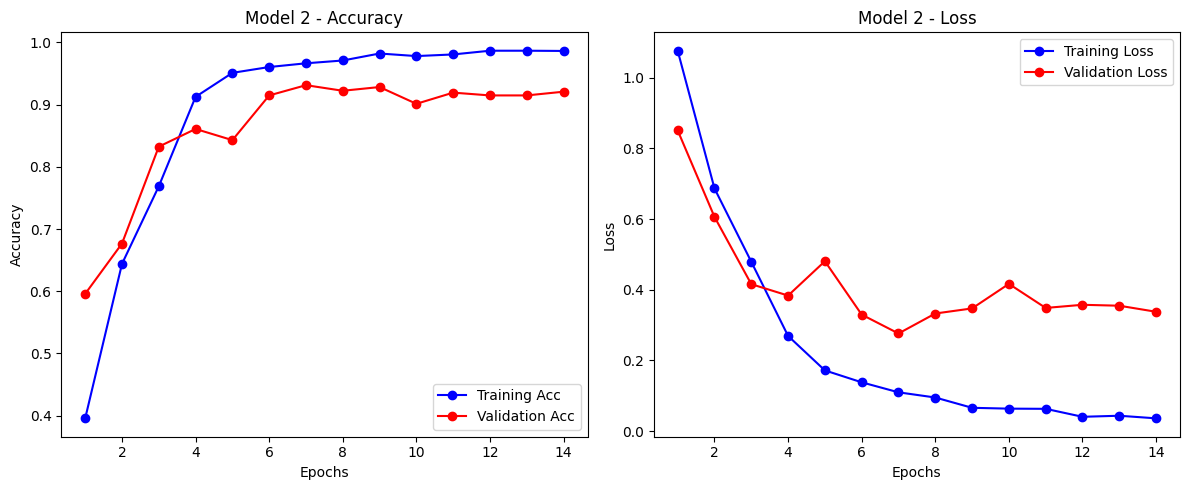


Evaluating Model 3: LSTM + Word2Vec...
Model 3: LSTM + Word2Vec Accuracy: 0.8543
Model 3: LSTM + Word2Vec Loss: 0.6480
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Classification Report for Model 3: LSTM + Word2Vec:

              precision    recall  f1-score   support

           0       0.68      0.82      0.75        61
           1       0.92      0.93      0.93       278
           2       0.78      0.69      0.73       114

    accuracy                           0.85       453
   macro avg       0.80      0.81      0.80       453
weighted avg       0.86      0.85      0.85       453



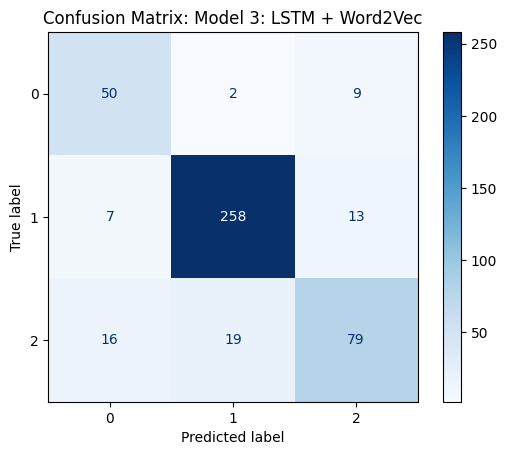

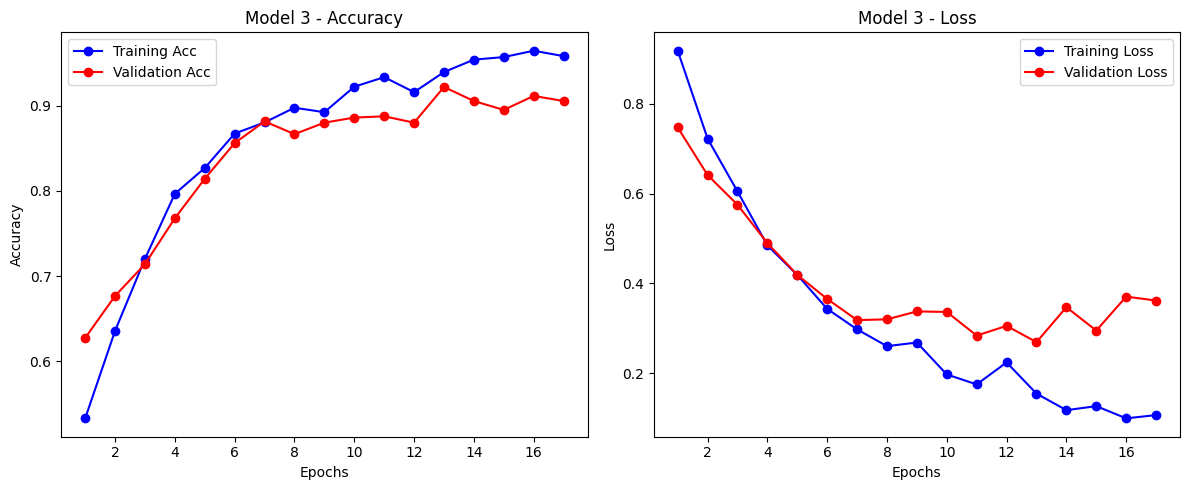


Final Comparison Summary:
Model 1: Accuracy=0.7748, Loss=1.0443
Model 2: Accuracy=0.8168, Loss=0.7401
Model 3: Accuracy=0.8543, Loss=0.6480
model1 training time: 12.17 seconds (0.20 minutes)
model2 training time: 17.26 seconds (0.29 minutes)
model3 training time: 19.79 seconds (0.33 minutes)


In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# === Evaluate Models ===
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\nEvaluating {model_name}...")
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Loss: {loss:.4f}")

    # Predict classes
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification Report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

    return accuracy, loss

# === Plot Training History ===
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# === Run for each model ===
acc1, loss1 = evaluate_model(model1, X_test_pad, y_test, "Model 1: Simple RNN")
plot_history(history1, "Model 1")

acc2, loss2 = evaluate_model(model2, X_test_pad, y_test, "Model 2: LSTM + Word Embedding")
plot_history(history2, "Model 2")

acc3, loss3 = evaluate_model(model3, X_test_pad, y_test, "Model 3: LSTM + Word2Vec")
plot_history(history3, "Model 3")

# === Final Summary ===
print("\nFinal Comparison Summary:")
print(f"Model 1: Accuracy={acc1:.4f}, Loss={loss1:.4f}")
print(f"Model 2: Accuracy={acc2:.4f}, Loss={loss2:.4f}")
print(f"Model 3: Accuracy={acc3:.4f}, Loss={loss3:.4f}")
for model_name, duration in training_times.items():
    print(f"{model_name} training time: {duration:.2f} seconds ({duration/60:.2f} minutes)")



In [22]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.6 MB/s eta 0:00:00


In [27]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prediction function
def predict_financial_phrase(phrase):
    cleaned = clean_text(phrase)
    # Step 2: Tokenize and pad
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=sequence_length, padding='post', truncating='post')

    # Predict
    prediction = model3.predict(padded)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Class mapping (adjust based on your actual label meanings)
    class_labels = {0: 'negative', 1: 'Neutral', 2: 'positive'}

    return f"Prediction: {class_labels[predicted_class]}"

# Create the Gradio interface
interface = gr.Interface(
    fn=predict_financial_phrase,
    inputs=gr.Textbox(lines=2, placeholder="Enter financial phrase..."),
    outputs="text",
    title="Financial Sentiment Classifier",
    description="Enter a financial phrase to predict its sentiment (Positive, Negative , Neutral)"
)

# Launch the GUI
interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5a095412862c5f8c15.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
